In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [20]:
a=datetime.datetime.strptime('2019-10-08', '%Y-%m-%d')
print(a)
print(type(a))

2019-10-08 00:00:00
<class 'datetime.datetime'>


In [23]:
def parser(x):
    return datetime.datetime.strptime(x, '%Y-%m')

In [24]:
data= pd.read_csv('AirPassengers.csv', date_parser=parser, parse_dates=[0], index_col=[0])

In [25]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


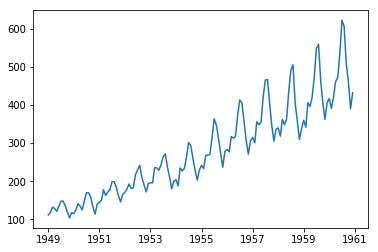

In [27]:
#plotting the data
plt.plot(data['#Passengers'])

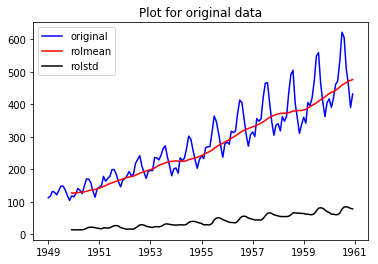

In [262]:
#determining the rolling stats of data
#Rolmean is used to smoothen the graph. Weactually deal with noice using rolling mean.
rolmean= data.rolling(window=12).mean()
rolstd= data.rolling(window=12).std()

orig= plt.plot(data, color='blue', label='original')
rolmean= plt.plot(rolmean, color='red', label='rolmean')
rolstd= plt.plot(rolstd, color='black', label='rolstd')
plt.legend(loc='best')
plt.title('Plot for original data')
plt.show()


In [57]:
#performing the dickey fuller test on original data
from statsmodels.tsa.stattools import adfuller
org_test= adfuller(data['#Passengers'])
org_output=pd.Series(org_test[0:4], index=['TestStatistics', 'P-value', '#lagsUsed', '#obs used'])
for key, value in org_test[4].items():
    org_output['critical_value {}'.format(key)]=value
org_output
#the stats came out to be non stationary

#The Time Series is still not stationary here 
#Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
#Seasonality – variations at specific time-frames. 

TestStatistics          0.815369
P-value                 0.991880
#lagsUsed              13.000000
#obs used             130.000000
critical_value 1%      -3.481682
critical_value 5%      -2.884042
critical_value 10%     -2.578770
dtype: float64

TestStatistics         -1.717017
P-value                 0.422367
#lagsUsed              13.000000
#obs used             130.000000
critical_value 1%      -3.481682
critical_value 5%      -2.884042
critical_value 10%     -2.578770
dtype: float64

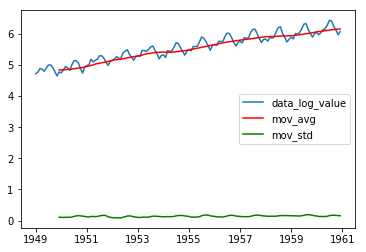

In [65]:
#using log of data and check stationarity
data_log_value= np.log(data)
mov_avg= data_log_value.rolling(window=12).mean()
mov_std= data_log_value.rolling(window=12).std()

plt.plot(data_log_value, label='data_log_value')
plt.plot(mov_avg, color='red', label='mov_avg')
plt.plot(mov_std, color='green', label='mov_std')
plt.legend()

#still the plot is not stationary

#performing the dickey fuller test on original data
from statsmodels.tsa.stattools import adfuller
org_test= adfuller(data_log_value['#Passengers'])
org_output=pd.Series(org_test[0:4], index=['TestStatistics', 'P-value', '#lagsUsed', '#obs used'])
for key, value in org_test[4].items():
    org_output['critical_value {}'.format(key)]=value
org_output

In [77]:
#Lets define a function to check stationarity further
def check_stationarity(dataset):
    rolling_mean= dataset.rolling(window=12).mean()
    rolling_std= dataset.rolling(window=12).std()
    plt.plot(dataset, color='blue', label='original')
    plt.plot(rolling_mean, color='red', label='rolling_mean')
    plt.plot(rolling_std, color='green', label='rolling_std')
    plt.legend(loc='best')
    plt.show()
    
    from statsmodels.tsa.stattools import adfuller
    test= adfuller(dataset['#Passengers'], autolag='AIC')
    output=pd.Series(test[0:4], index=['TestStatistics', 'P-value', '#lagsUsed','#ObsUsed'])
    for key,value in test[4].items():
        output['Critical_value {}'.format(key)]= value
   
    display(output)  

In [85]:
#lets shift the data by one and check the stationarity for data without log
data_1Lag= data.shift(periods=1)
dataMinusdata1Lag= data-data_1Lag
dataMinusdata1Lag.dropna(inplace=True)

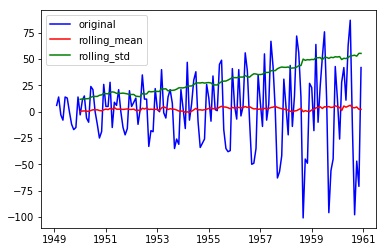

TestStatistics         -2.829267
P-value                 0.054213
#lagsUsed              12.000000
#ObsUsed              130.000000
Critical_value 1%      -3.481682
Critical_value 5%      -2.884042
Critical_value 10%     -2.578770
dtype: float64

In [84]:
check_stationarity(dataMinusdata1Lag)

#seems like the rolling mean is constant but still variance is there so it cant be stationary.

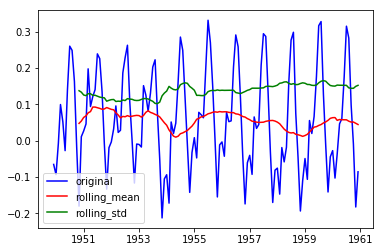

TestStatistics         -3.162908
P-value                 0.022235
#lagsUsed              13.000000
#ObsUsed              119.000000
Critical_value 1%      -3.486535
Critical_value 5%      -2.886151
Critical_value 10%     -2.579896
dtype: float64

In [94]:
#1 Checking stationarity for #data_log_valueMinusmov_avg 
#It is taking rolling mean(12)of log data and then subratcting from original log data

data_log_value= np.log(data)
mov_avg= data_log_value.rolling(window=12).mean()
mov_std= data_log_value.rolling(window=12).std()

data_log_valueMinusmov_avg= data_log_value-mov_avg
data_log_valueMinusmov_avg.dropna(inplace=True)

check_stationarity(data_log_valueMinusmov_avg)

#Here the result came out is stationary data

From above graph, we observe that our intuition that "subtracting two related series having similar trend components will make the result stationary" is true. We find that:

p-value has reduced from 0.99 to 0.022.
The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus, from above 2 points, we can say that our given series is stationary.
But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

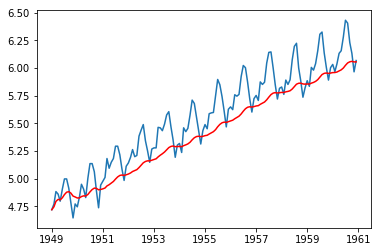

In [104]:
#2 (Without subtraction)
#Exponential weighted average
exponentialDecayWeightedAvg= data_log_value.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(data_log_value)
plt.plot(exponentialDecayWeightedAvg, color='red')

#The Exponential weighted average data is not stationary

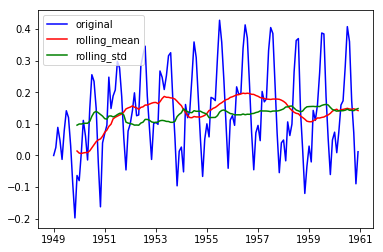

TestStatistics         -3.601262
P-value                 0.005737
#lagsUsed              13.000000
#ObsUsed              130.000000
Critical_value 1%      -3.481682
Critical_value 5%      -2.884042
Critical_value 10%     -2.578770
dtype: float64

In [106]:
#Now taking the subtracted data for Exponential weighted average

data_log_valueMinusexponentialDecayWeightedAvg= data_log_value-exponentialDecayWeightedAvg
check_stationarity(data_log_valueMinusexponentialDecayWeightedAvg)

#The data comes out here is stationary 

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.
Also,

p-value has decreased from 0.022 to 0.005.
Test Statistic value is very much closer to the Critical values.
Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.

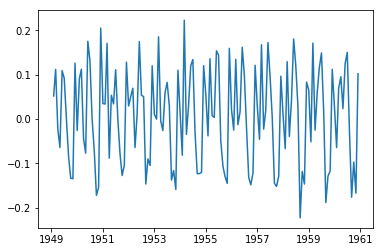

In [111]:
#3 Differencing
#Shifting Log value by one
data_log_value_shift= data_log_value-data_log_value.shift(1)
data_log_value_shift.dropna(inplace=True)
plt.plot(data_log_value_shift)

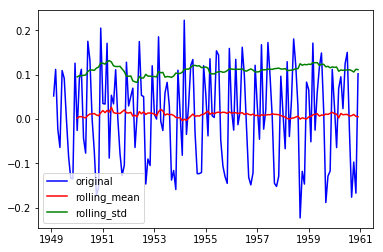

TestStatistics         -2.717131
P-value                 0.071121
#lagsUsed              14.000000
#ObsUsed              128.000000
Critical_value 1%      -3.482501
Critical_value 5%      -2.884398
Critical_value 10%     -2.578960
dtype: float64

In [112]:
check_stationarity(data_log_value_shift)
#the data comes out here is also stationary.

#Lets take this to build our ARIMA model

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

p-value of 0.07 is not as good as 0.005 of exponential decay.
Test Statistic value not as close to the critical values as that for exponential decay.
We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

In [114]:
#Components of Timeseries
#Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
decompose= seasonal_decompose(data_log_value)

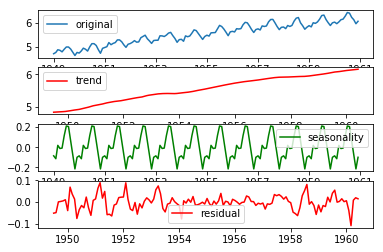

In [122]:
trend= decompose.trend
seasonal= decompose.seasonal
residual=decompose.resid

plt.subplot(411)
plt.plot(data_log_value, label='original')
plt.legend()

plt.subplot(412)
plt.plot(trend, color='red', label='trend')
plt.legend()

plt.subplot(413)
plt.plot(seasonal, color='green', label='seasonality')
plt.legend()

plt.subplot(414)
plt.plot(residual, color='red', label='residual')
plt.legend()


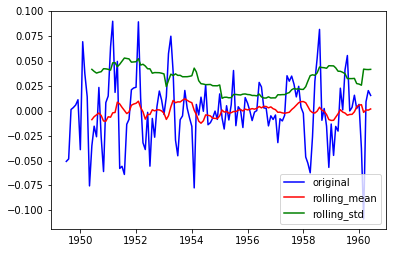

TestStatistics       -6.332387e+00
P-value               2.885059e-08
#lagsUsed             9.000000e+00
#ObsUsed              1.220000e+02
Critical_value 1%    -3.485122e+00
Critical_value 5%    -2.885538e+00
Critical_value 10%   -2.579569e+00
dtype: float64

In [124]:
residual.dropna(inplace=True)
check_stationarity(residual)

In [ ]:
#Lets build our model using differencing as it is very popular technique. Apart from that its easier to add noice and seasonality
#back into predicted value

In [245]:
#ACF and #PACF value
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf= acf(data_log_value_shift, nlags=10)
pacf=pacf(data_log_value_shift, nlags=10, method='ols')

Text(0.5,1,'PartialAutoCorrelation Function')

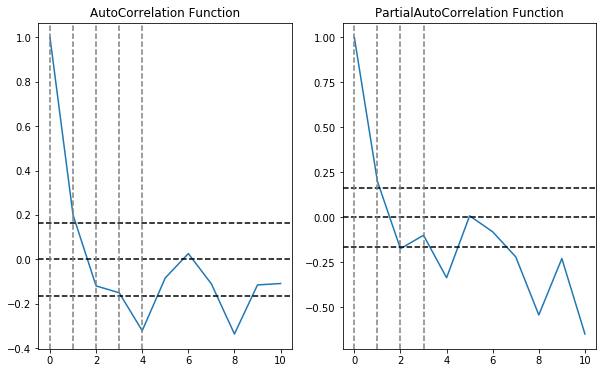

In [247]:
#Plot ACF
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0, linestyle='--', color='black')
plt.axhline(y=-1.96/np.sqrt(len(data_log_value_shift)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(data_log_value_shift)), linestyle='--', color='black')
plt.axvline(x=0, linestyle='--', color='grey')
plt.axvline(x=1, linestyle='--', color='grey')
plt.axvline(x=2, linestyle='--', color='grey')
plt.axvline(x=3, linestyle='--', color='grey')
plt.axvline(x=4, linestyle='--', color='grey')
plt.title('AutoCorrelation Function')


plt.subplot(122)
plt.plot(pacf)
plt.axhline(y=0, linestyle='--', color='black')
plt.axhline(y=-1.96/np.sqrt(len(data_log_value_shift)), linestyle='--', color='black')
plt.axhline(y=1.96/np.sqrt(len(data_log_value_shift)), linestyle='--', color='black')
plt.axvline(x=0, linestyle='--', color='grey')
plt.axvline(x=1, linestyle='--', color='grey')
plt.axvline(x=2, linestyle='--', color='grey')
plt.axvline(x=3, linestyle='--', color='grey')
plt.title('PartialAutoCorrelation Function')

Text(0.5,1,'PartialAutocorrelation Function')

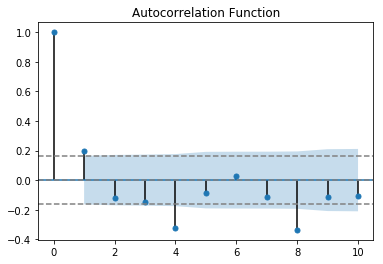

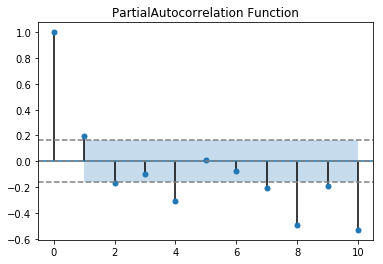

In [252]:
plot_acf(data_log_value_shift, lags=10)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_value_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_value_shift)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plot_pacf(data_log_value_shift, lags=10)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_value_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_value_shift)),linestyle='--',color='gray')
plt.title('PartialAutocorrelation Function')

-287.2808079189693
0.08483434965730996
RMSE value is 1.0291519640943583


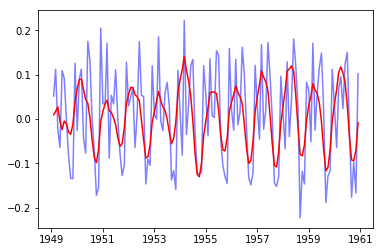

In [260]:
#we can take (1,1) or (2,2) value as both lies above the boundary line(dashed line)
#ARIMA Model
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA

model_ARIMA1= ARIMA(data_log_value, order=(2,1,2))
result1= model_ARIMA1.fit()
print(result1.aic)

plt.plot(data_log_value_shift, color='blue', alpha=0.5 )
plt.plot(result1.fittedvalues, color='red')


from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(data_log_value_shift, result1.fittedvalues)))
print('RMSE value is {}'.format(sum((data_log_value_shift['#Passengers']-result1.fittedvalues)**2)))

In [168]:
#Lets use AIC to find the best values
import itertools
p=d=q=range(0,5)
pdq= list(itertools.product(p,d,q))

for i in pdq:
    try:
         model_ARIMA1= ARIMA(data_log_value, order=i)
         result1= model_ARIMA1.fit()
         print(i, result1.aic)
    except:
        continue

(0, 0, 0) 176.16013178020134
(0, 0, 1) 6.876243369729423
(0, 1, 0) -231.56489500229378
(0, 1, 1) -237.50731498554302
(0, 1, 2) -240.3789540202502
(0, 1, 3) -257.89027079806846
(0, 1, 4) -277.22711947637873
(0, 2, 0) -162.71343086452043
(0, 2, 1) -222.11663324938877
(0, 2, 2) -228.41156486222428
(0, 2, 3) -230.5917079739222
(1, 0, 0) -228.1309225772132
(1, 0, 1) -235.40775663041046
(1, 0, 2) -236.29545049871302
(1, 0, 3) -67.25369517604685
(1, 0, 4) -159.3962650609464
(1, 1, 0) -235.38589888263226
(1, 1, 1) -241.60771402611334
(1, 1, 2) -265.1896905950195
(1, 1, 3) -263.233316354347
(1, 1, 4) -275.46025877158496
(1, 2, 0) -173.73789389552246
(2, 0, 0) -233.2827466954662
(2, 0, 1) -238.67311503295326
(2, 0, 2) -231.70002427800017
(2, 0, 3) -232.84555042355709
(2, 0, 4) -237.1363313590951
(2, 1, 0) -237.60463569752818
(2, 1, 1) -270.1512043857046
(2, 1, 2) -287.2808079189693
(2, 1, 3) -279.99943059073036
(2, 1, 4) -292.5298810613912
(2, 2, 0) -184.75400041272178
(2, 2, 1) -228.17349296883

In [194]:
predicted_ARIMA_diff= result1.fittedvalues
predicted_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [213]:
predicted_ARIMA_diff_cumsum= np.cumsum(predicted_ARIMA_diff)
predicted_ARIMA_diff_cumsum.head(10)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
1949-07-01    0.021984
1949-08-01    0.011007
1949-09-01   -0.018922
1949-10-01   -0.053390
1949-11-01   -0.064668
dtype: float64

In [226]:
predicted_log_value= pd.Series(data_log_value['#Passengers'].iloc[0], index=data_log_value.index).add(predicted_ARIMA_diff_cumsum
                                                                                                   ,fill_value=0)

In [227]:
predicted_log_value.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

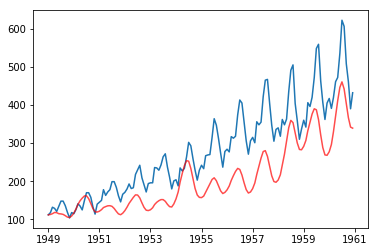

0.431922202021065

In [234]:
prediction_ARIMA= np.exp(predicted_log_value)
plt.plot(data)
plt.plot(prediction_ARIMA, color='red', alpha=0.7)
plt.show()

from sklearn import metrics
metrics.r2_score(data, prediction_ARIMA)

In [235]:
data.shape

(144, 1)

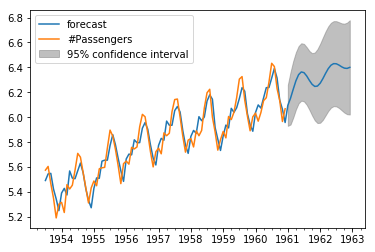

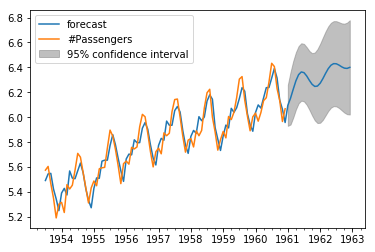

In [261]:
#lets predict for next 10 years
result1.plot_predict(start='1953-07-01', end='1962-12-01')

In [242]:
#forcasting the log value for next 10 years
result1.forecast(120)

(array([6.09553417, 6.15281441, 6.22442999, 6.29241111, 6.34164688,
        6.36359292, 6.35784582, 6.33139185, 6.29597428, 6.2644763 ,
        6.24738284, 6.25025172, 6.27275868, 6.30940355, 6.35151525,
        6.38988655, 6.41727338, 6.43010969, 6.42906574, 6.41842364,
        6.40456041, 6.39403531, 6.39183035, 6.40019491, 6.41833704,
        6.44295425, 6.46937439, 6.49293962, 6.5102406 , 6.51988943,
        6.52267468, 6.52112271, 6.51864422, 6.51853608, 6.52311869,
        6.53322331, 6.54812855, 6.56591543, 6.58410282, 6.60036492,
        6.61313194, 6.62192688, 6.62737683, 6.63093022, 6.63438592,
        6.63937904, 6.64696442, 6.65739793, 6.67015285, 6.6841421 ,
        6.69806575, 6.71077834, 6.72157649, 6.73033888, 6.73749708,
        6.74386276, 6.75037227, 6.75782508, 6.76668609, 6.77699758,
        6.78841258, 6.80032789, 6.81207123, 6.82308678, 6.83307044,
        6.84202392, 6.85022208, 6.85811118, 6.86617242, 6.8747906 ,
        6.88416218, 6.89426303, 6.90487809, 6.91